In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [31]:
#The following function returns all of the EMA data for each student, and compiles it onto one dataframe.
def combine_daily_emas(ema_name): 
    """
    input: ema_name -- name of the ema we're looking at
    output: dataframe containing the data from the desired ema compiled for all uids
    """
    # list of all the desired ema's 
    all_emas = glob.glob('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_*.json')
    # index to start the uid
    uid_start = len('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name +'_')
    # this is where we'll compile the data
    total_ema_data = pd.DataFrame()
    # loops through all the ema data
    for ema in all_emas: 
        # the uid is the three characters starting at uid_start index
        uid = ema[uid_start:uid_start + 3]
        # read the data
        ema_data = pd.read_json(ema)
        # keep track of day and day of week
        try:
            ema_data['doy'] = ema_data['resp_time'].dt.dayofyear 
            ema_data['day of week'] = ema_data['resp_time'].dt.dayofweek
            ema_data = ema_data.groupby('doy').mean()
            ema_data['day'] = ema_data.index
        except:
            # in this case there is an empty dataframe for this uid
            continue
        
        # keep track of uids
        ema_data['uid'] = uid
        
        # compile the data
        total_ema_data = total_ema_data.append(ema_data)

    return total_ema_data    

In [32]:
# The following function merges the desired EMAs for each student.
def merge_EMA(EMA_list): 
    """
    input: EMA_list -- contains a list of tuples, each tuple containing the name of an EMA and the name of a desired column
    in that EMA.
    output: a dataframe combining all those EMA's for every user. 
    """
    initialized = False
    for tup in EMA_list: 
        ema = tup[0]
        col = tup[1]
        ema_for_all_students = combine_daily_emas(ema)
        
        relevant_columns = ema_for_all_students[[col, 'day', 'day of week', 'uid']]
        
        if initialized is False: 
            initialized = True
            overall_merge = relevant_columns
        else: 
            overall_merge = overall_merge.merge(relevant_columns, on = ['day', 'day of week', 'uid'], how = 'inner')
    
    return overall_merge

In [38]:
# The following function returns the feature importances for the models we will run down the line.
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

def model_importance(model, features, target, features_names): 
    """
    given input features and targets (labels), a random forest model is created to 
    """
    n_features = features.shape[1]
    print(cross_val_score(model, features, target, cv = 5))
    model.fit(features, target)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')
    return model.feature_importances_

In [39]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_day

In [40]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
def pam(uid): 
    """
    This function compiles all of the relevant sensor day for our model: 
    Avg. Activity inference, total activity duration (as Time Delta), sleep duration, # of bluetooth colocations, # of unique locations, 
    total darkness duration, conversation duration, and conversation frequency during the day, evening and night epochs.
    """
    pam = pd.read_json('dataset/dataset/EMA/response/PAM/PAM_' + uid + '.json')
    pam = pam.dropna()
    pam['day'] = pam['resp_time'].dt.dayofyear
    pam = pam.groupby('day').mean()
    # since pam levels are discrete, we want to take the nearest overall PAM level for the day 
    pam = pam.apply(lambda x: round(x))
    pam['doy'] = pam.index
    
    # The following code reads the relevant sensor data to compile our features.
    
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    #To find daily activity, we call the function from the previous cell that finds total activity time per day.
    daily_activity_dur = activity_analysis(uid)
    activity_feat = pd.merge(daily_activity, daily_activity_dur, on='day', how='inner')
    
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['start hour'] = pd.to_datetime(conversation['start_timestamp'], unit='s').dt.hour
    conversation['end hour'] = pd.to_datetime(conversation[' end_timestamp'], unit='s').dt.hour
    conversation['convo_duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['epoch'] = list(zip(conversation['start hour'], conversation['end hour']))
    def epoch(times_tuple):        
        start = times_tuple[0]
        end = times_tuple[1]
        
        if (start and end) > 10 and (start and end) <=18:
            return 'Day'
        elif (start and end) >0 and (start and end) <=10:
            return 'Night'
        elif (start and end) >18:
            return 'Evening'
    
    conversation['epoch'] = conversation['epoch'].apply(epoch)
    conversation['day epoch'] = conversation['epoch']=='Day'
    conversation['eve epoch'] = conversation['epoch']=='Evening'
    conversation['night epoch'] = conversation['epoch']=='Night'
    conversation = conversation.replace(False, np.nan)
    conversation_freqs = conversation.groupby('day').count()
    
    
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    
    features_list = [(activity_feat, ' activity inference'), (activity_feat, 'Time Delta'), (darkness, 'dark duration'), 
                     (bluetooth, 'number colocations'), 
                     (conversation_freqs, 'convo_duration'), (conversation_freqs, 'day epoch'), (conversation_freqs, 'eve epoch'), (conversation_freqs, 'night epoch'), 
                     (wifi_locations, 'unique locations')]
    
    # The following lines of code combines all of the feature (sensor) and target (PAM) data onto one dataframe.
    data = pam
    for feat in features_list: 
        #print(data.shape)
        data = data.merge(feat[0][[feat[1]]], 
                                left_on = 'doy', right_on = 'day', how = 'inner')
        
    
    features_names = [' activity inference', 'Time Delta', 'dark duration',
                     'number colocations', "convo_duration", 'day epoch', 'eve epoch', 'night epoch', 'unique locations']
    features = data[features_names].values
    
    target = data['picture_idx'].values
    
    
    #The following line of code returns a plot of the feature importances by calling a previous function.
    feat_import = model_importance(GradientBoostingClassifier(), features, target, features_names)
    
    return feat_import, features_names


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.         0.         0.         0.        ]


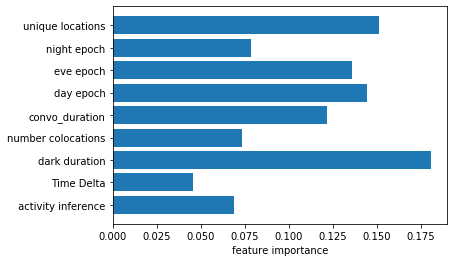

In [41]:
#This is a feature importance plot from using the GradientBoostingClassifier
x = pam('u07')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.125      0.         0.         0.        ]


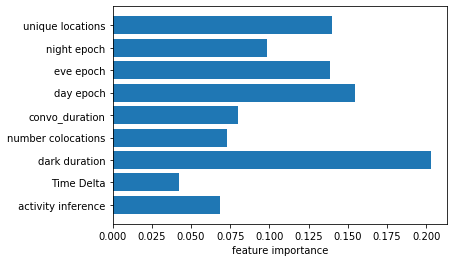

In [42]:
#This is a feature importance plot from using the RandomForestClassifier
y = pam('u07')

In [43]:
#This function returns the feature importances for all students.
def compile_feat_imports(): 

    pam_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    counter = 1
    # loops through all the files and averages the feature importance lists
    for file in pam_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        
        try:
            # Importane is obtained from the previous feature importance function (labeled as pam)
            importance = pam(uid)
        except: 
            # in the case there was no data in the user's ema file,  we skip that user. 
            continue 
        
        if importance is None:
            continue 
        
        if counter == 1: 
            uid_feature_importance = pam(uid)[0]
        else: 
            uid_feature_importance = (uid_feature_importance*(counter - 1) + pam(uid)[0])/counter
        counter += 1
        
    return uid_feature_importance

In [45]:
# This function orders and sorts the sensor data.
def order(feat_imp, sensors): 
    """
    inputs: feat_imp -- array containing the importance of each sensor
            sensors -- the sensor corresponding to each element in the array
    """
    # sort from least to greatest
    sorty = np.sort(feat_imp)
    
    # make a dictionary where the key is the feature importance and the value is the sensor 
    # im making the assumption that no two keys will be the same since there are not many sensors and 
    # accuracy is to many decimals. 
    sorty_dict = {}
    for i in range(len(feat_imp)): 
        sorty_dict[feat_imp[i]] = sensors[i]
    
    # make a sorted sensors list using the dictionary
    sorted_sensors = []
    for elem in sorty: 
        sorted_sensors.append(sorty_dict[elem])
    
    # reverse so the order is most important to least important sensor
    sorted_sensors.reverse()
    
    return sorted_sensors

In [46]:
#This function ranks feature data for each student with respect to predicting their PAM values.
#The rankings are returned as a dictionary.
def rankings():
    pam_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    counter = 1
    # this dictionary will keep track of the most important sensor for each user. 
    most_imp_dict = {}
    # loops through all the files and averages the feature importance lists
    for file in pam_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        # find feature importance
        try:
            res = pam(uid)
        except:
        #print(uid)
            continue
        if res is None: 
            continue
        feat_imp = res[0]
        sensors = res[1]
        # reorder the features here
        most_imp_dict[uid] = order(feat_imp, sensors)
    return most_imp_dict

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.09090909 0.         0.         0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.33333333 0.22222222 0.125      0.5        0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.         0.         0.08333333 0.14285714 0.2       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.         0.         1.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0. 0. 0. 0. 0.]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.16666667 0.         0.1        0.125      0.33333333]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.  0.  0.  0.  0.2]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.2        0.33333333 0.1        0.11111111 0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.23076923 0.3        0.2        0.25       0.5       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.13333333 0.         0.         0.33333333 0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.         0.14285714 0.         1.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.15384615 0.25       0.16666667 0.         0.2       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.2        0.125      0.42857143 0.4       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.         0.         0.11111111 0.11111111 0.33333333]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.2        0.33333333 0.4        1.         0.66666667]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.125 0.    0.25  0.    0.   ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.05882353 0.16666667 0.2        0.33333333 0.55555556]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.38461538 0.18181818 0.1        0.28571429 0.28571429]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.21428571 0.41666667 0.3        0.22222222 0.22222222]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.33333333 0.25       0.75       0.33333333]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.1        0.28571429 0.33333333 0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.07692308 0.11111111 0.2        0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.         0.42857143 0.2        0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.05882353 0.13333333 0.25       0.27272727 0.11111111]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.07692308 0.2        0.28571429 0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.         0.         0.1        0.11111111 0.28571429]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.1 0.  0.  1.  0. ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.25       0.2        0.125      0.25       0.14285714]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.25       0.33333333 0.18181818 0.11111111 0.2       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.08333333 0.11111111 0.16666667 0.33333333 0.33333333]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.23076923 0.125      0.33333333 0.5        1.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.15384615 0.         0.         0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.10526316 0.21428571 0.09090909 0.         0.14285714]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.25       0.         0.11111111 0.         0.11111111]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0. 0. 0. 0. 0.]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.15384615 0.11111111 0.125      0.         0.33333333]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.18181818 0.         0.         0.         0.        ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.11764706 0.         0.         0.28571429 0.2       ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0.2        0.         0.33333333 0.5        0.        ]


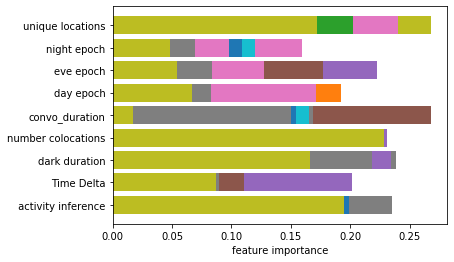

In [47]:
rankings = rankings()

In [54]:
#Using sensor ranking data, this function returns histogram plots to show the distribution of feature importances.
def plot_ranking(sensor_rankings): 
    
    rank_df = pd.DataFrame(rankings)
    # Since the original rank_df has rankings as rows and students as columns, we take the transpose.
    #The transpose dataframe will have rankings as columns and uids as each row.
    rank_df = rank_df.transpose()
    
    # make the plot with two subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 10)) 
    # first subplot
    #This subplot returns a plot of the distribution of feature importances:
        #Returns how many students have a particular feature as their most important feature.
    ax1.hist(rank_df[0], rwidth = 0.75)
    ax1.set_ylabel('number of users')
    ax1.set_title('most important sensor for predicting daily PAM (by user)')
    
    # second subplot
    #This subplot returns a plot of the distribution of least important features:
        #Returns the amount of students for whom a particular feature is the least important.
    ax2.hist(rank_df[8], rwidth=0.75)
    ax2.set_ylabel('number of users')
    ax2.xaxis.label.set_fontsize(15)
    ax2.set_title('least important sensor for predicting daily PAM (by user)')
    
    for label in ax1.get_xticklabels() + ax2.get_xticklabels():
        label.set_fontsize(12)
        
    for label in ax1.get_yticklabels() + ax2.get_yticklabels():
        label.set_fontsize(15)
    
    rank_df.columns = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth']
    
    return rank_df

In [55]:
#This function plots the feature importance distribution.
def compile_clustering_features(): 

    rankings_df = plot_ranking(rankings)
    rankings_df['id'] = rankings_df.index
    
    features_df = rankings_df    
    
    return features_df

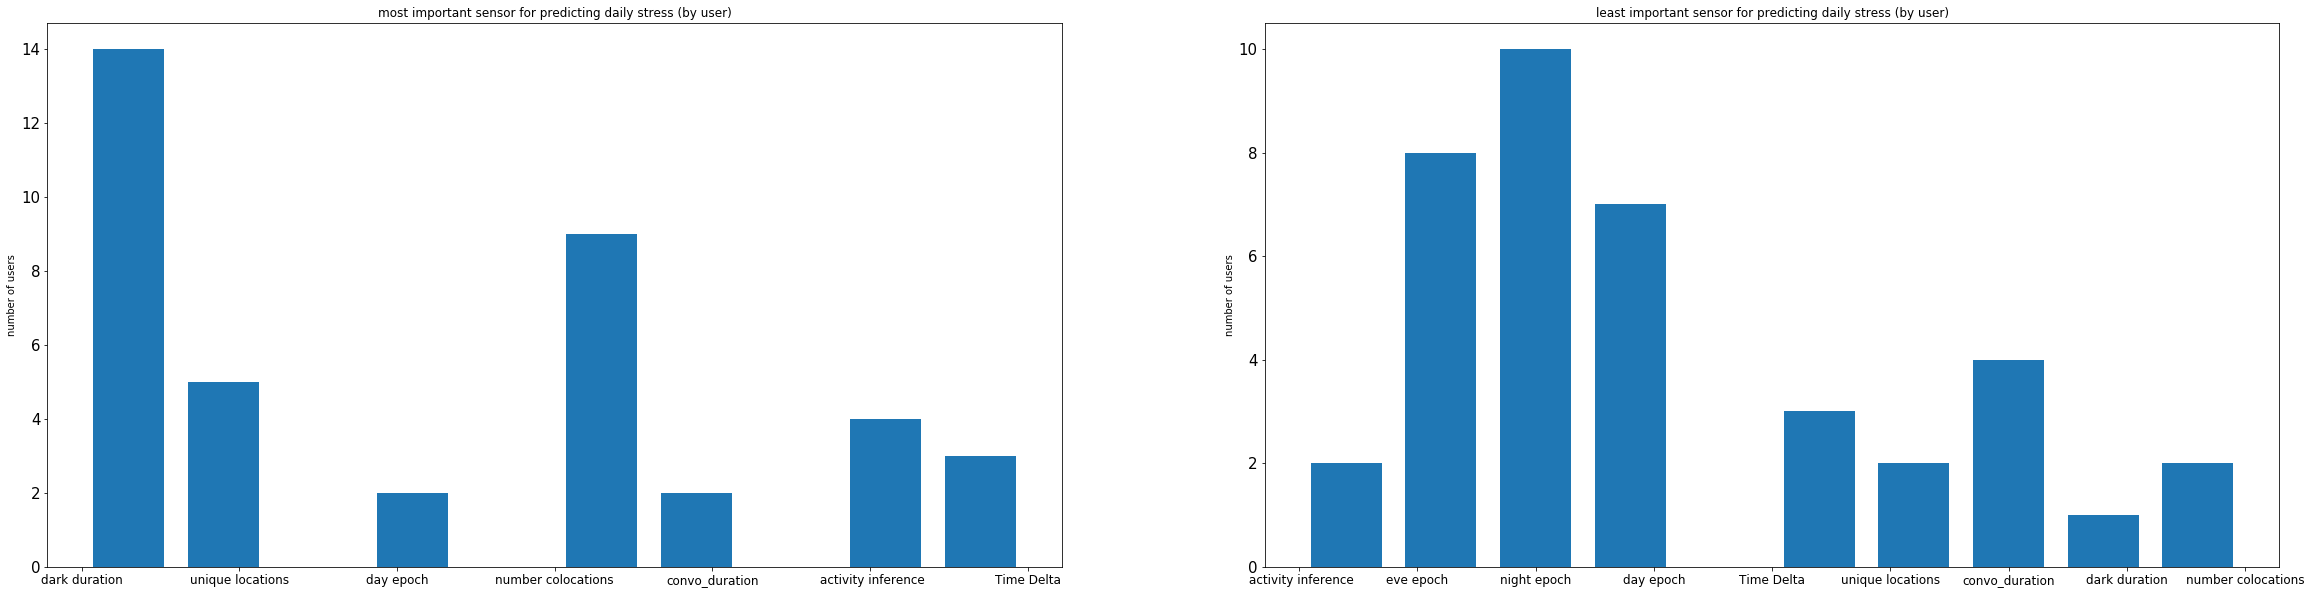

In [56]:
compiled_features = compile_clustering_features()

In [ ]:
# All the following survey processing code is adapted from the notebook "Survey Dataset V2" 
# This is adapted from another student's code.

# This function processes perceived stress scale (pre and post) surveys 

def pss_analysis(pss_survey):
    """
    Consolidates the  block of code necessary to generate the PSS survey visualizations for
    added modularity of notebook. Running it on the raw PSS data prepares the graphs related
    to this piece of the dataset.
    
    @param: pss_survey – raw data for PSS survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for PSS survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_pss = pss_survey[pss_survey.type == 'pre'].drop('type', axis=1)
    post_pss = pss_survey[pss_survey.type == 'post'].drop('type', axis=1)

    def remodel_columns_pss(data):
        """
        Replaces the wordy columns for indices q1-q10. Since PSS
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_pss(entry):
        """
        Replaces string response for corresponding value 0-4.

        @param: dataframe entry containing PSS survey answer

        returns: value 0-4 replacing str answer
           """
        if entry == 'Never':
            return 0
        if entry == 'Almost never':
            return 1
        if entry == 'Sometime':
            return 2
        if entry == 'Fairly often':
            return 3
        if entry == 'Very often':
            return 4
        return entry

    def remodel_data_pss(data):
        """
        Combines functionalities of remodel_columns_pss and numerify_data_pss
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns and values 0-4
        replacing original str answers in q1-q10, with new columns 'score'
        with each student's test score
        """
        data = remodel_columns_pss(data)
        data = data.applymap(numerify_data_pss)
        # Reverse scoring for particular questions
        for question in {'q4', 'q5', 'q7', 'q8'}:
            data[question] = data[question].apply(lambda x: 4 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_pss_m = remodel_data_pss(pre_pss)
    post_pss_m = remodel_data_pss(post_pss)

    return pre_pss_m, post_pss_m

In [ ]:
# All the following loneliness survey processing code is adapted from the notebook "Survey Dataset V2" 
# This is adapted from another student's code.

# This function processes loneliness scale (pre and post) surveys 

def lonely_analysis(lonely):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_lonely = lonely[lonely.type == 'pre'].drop('type', axis=1)
    post_lonely = lonely[lonely.type == 'post'].drop('type', axis=1)

    def remodel_columns_lonely(data):
        """
        Replaces the wordy columns for indices q1-q20. Since LonelinessScale
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_lonely(entry):
        """
        Replaces string response for corresponding value 1-4.

        @param: dataframe entry containing LonelinessScale survey answer

        returns: value 1-4 replacing str answer
        """
        if entry == 'Never':
            return 1
        if entry == 'Rarely':
            return 2
        if entry == 'Sometimes':
            return 3
        if entry == 'Often':
            return 4
        return entry

    def remodel_data_lonely(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_lonely(data)
        data = data.applymap(numerify_data_lonely)
        for question in {'q1', 'q5', 'q6', 'q9', 'q10',
                         'q15', 'q16', 'q19', 'q20'}:
            data[question] = data[question].apply(lambda x: 5 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_lonely_m = remodel_data_lonely(pre_lonely)
    post_lonely_m = remodel_data_lonely(post_lonely)
    
    return pre_lonely_m, post_lonely_m

In [ ]:
# This function is modeled off of another student's survey anaylsis code as shown above.
# This function returns processed PHQ-9 survey (pre and post) results.
def depression_analysis(phq9):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_phq9 = phq9[phq9.type == 'pre'].drop('type', axis=1)
    post_phq9 = phq9[phq9.type == 'post'].drop('type', axis=1)

    def remodel_columns_phq9(data):
        """
        Replaces the wordy columns for indices q1-q20. Since LonelinessScale
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_phq9(entry):
        """
        Replaces string response for corresponding value 1-4.

        @param: dataframe entry containing LonelinessScale survey answer

        returns: value 1-4 replacing str answer
        """
        if response == 'Not at all':
            return 0
        elif response == 'More than half the days':
            return 2
        elif response == 'Several days':
            return 1
        elif response == 'Nearly every day':
            return 3
        #else:
        return response

    def remodel_data_phq9(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_lonely(data)
        data = data.applymap(numerify_data_lonely)
        #for question in {'q1', 'q5', 'q6', 'q9', 'q10',
                        # 'q15', 'q16', 'q19', 'q20'}:
            #data[question] = data[question].apply(lambda x: 5 - x)
        data['score'] = data.sum(axis=0, numeric_only=True)
        data['id'] = data.index
        return data

    pre_phq9_m = remodel_data_phq9(pre_phq9)
    post_phq9_m = remodel_data_phq9(post_phq9)
    
    return pre_phq9_m, post_phq9_m

In [ ]:
# While I was able to plot feature importances for PAM and was able to return histogram
# distributions of feature importance, I did not try to cluster students based off of survey data (i.e. PHQ-9 or loneliness)
# to try and identify any patterns among students.

# I also did not check model performance before proceeding with feature importance, and it's something I hope to incorporate for next week.
# Finally, I only used two classifying algorithms: GradientBoosting and RandomForest.
# I hope to use more algorithms and aggregate their feature importance distribution results.